In [1]:
%%capture
!pip install wandb -qU

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jissu02. Use `wandb login --relogin` to force relogin


True

In [3]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn
from torch import optim
from datetime import datetime
from pathlib import Path
from torch.utils.data import random_split, DataLoader

# [문제 1] Fashion Mnist 데이터 정규화를 위한 Mean 값과 Std 값 찾기

In [4]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

In [5]:
data_path = "."

f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

In [6]:
print(len(f_mnist_train), len(f_mnist_validation))  # >>> 55000 5000

img_t = f_mnist_train[0][0]
label = f_mnist_train[0][1]
print(type(img_t))
print(img_t.shape)
print(img_t.min(), img_t.max())

55000 5000
<class 'torch.Tensor'>
torch.Size([1, 28, 28])
tensor(0.) tensor(1.)


In [7]:
imgs = torch.stack([img_t for img_t, _ in f_mnist_train], dim=3)
print(imgs.shape)
# >>> torch.Size([1, 28, 28, 55000])

print(imgs.view(1, -1).mean(dim=-1))
print(imgs.view(1, -1).std(dim=-1))

torch.Size([1, 28, 28, 55000])
tensor([0.2863])
tensor([0.3532])


mean = 0.2863, std = 0.3532

# [문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기

## GET DATA

In [8]:
import os
import sys


def is_linux():
    if sys.platform.startswith("linux"):
        return True
    else:
        return False


def is_windows():
    if os.name == "nt":
        return True
    else:
        return False


def is_mac():
    if sys.platform == "darwin":
        return True
    else:
        return False


def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()


from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)


def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )


if __name__ == "__main__":
    if is_linux():
        print("Linux")
    elif is_windows():
        print("Windows")
    elif is_mac():
        print("Mac")
    else:
        print("<unknown>")


Linux


### a_fashion_mnist_data.py 코드

In [9]:
BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
print(BASE_PATH)

import sys

sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows

/home/work/DL/link_dl


In [10]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2863, std=0.3532),   # 값 변경
    )

    return train_data_loader, validation_data_loader, f_mnist_transforms

In [11]:
def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=128, shuffle=False)

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2863, std=0.3532),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [12]:
if __name__ == "__main__":
    config = {'batch_size': 2048, }
    wandb.init(mode="disabled", config=config)

    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
    print()
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()


Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


## Train

### ClassificationTrainer

In [13]:
# 조기 종료
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=5, delta=0.0001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:6.3f} --> {new_validation_loss:6.3f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    print(f"Attempting to save checkpoint at: {self.file_path}")
    print(f"Write permission for path: {os.access(os.path.dirname(self.file_path), os.W_OK)}")
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss

In [14]:
class ClassificationTrainer:
  # 클래스 초기화 (매개변수 받아 인스턴스 변수로 저장)
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path
    
    # 쓰기 권한 확인
    print(f"Checkpoint directory: {self.checkpoint_file_path}")
    print(f"Write permission for path: {os.access(self.checkpoint_file_path, os.W_OK)}")

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  # 모델 학습시키는 메소드
  def do_train(self):
    self.model.train()

    loss_train = 0.0  #손실
    num_corrects_train = 0  #올바르게 예측된 샘플 수
    num_trained_samples = 0 # 처리한 학습 샘플 수
    num_trains = 0 #배치 수

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms: # 전처리 변환 지정 되면 입력데이터 전처리 변환
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train) # 손실계산
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1) #예측 클래스 계산
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train) #처리한 샘플 수 누적
      num_trains += 1

      self.optimizer.zero_grad() #그래디언트 초기화
      loss.backward()
      self.optimizer.step() #파라미터 업데이트

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy  # 평균 훈련 손실과 훈련 정확도를 반환

  def do_validation(self):
    self.model.eval()   # 모델을 평가 모드로 설정

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    
    print("CHECKPOINT_FILE_PATH:", self.checkpoint_file_path)  # 추가된 코드
    
    
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:6.4f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:6.4f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

### get_cnn_model

In [ ]:
def get_cnn_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 24 x 24 --> B x 6 x 12 x 12
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 8 x 8 --> B x 16 x 4 x 4
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 1 * 28 * 28
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

In [ ]:
def get_cnn_model_with_dropout():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 24 x 24 --> B x 6 x 12 x 12
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 8 x 8 --> B x 16 x 4 x 4
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.3),      # p: dropout probability
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 3 * 32 * 32
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

In [ ]:
def get_cnn_model_with_batch_normalization():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 24 x 24 --> B x 6 x 12 x 12
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(num_features=6, eps=1e-04, momentum=0.1),
        nn.ReLU(),
        # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 8 x 8 --> B x 16 x 4 x 4
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(num_features=128, eps=1e-05, momentum=0.1),
        nn.ReLU(),
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 3 * 32 * 32
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

In [ ]:
def get_cnn_model_with_layer_normalization():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 24 x 24 --> B x 6 x 12 x 12
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LayerNorm(normalized_shape=[6, 12, 12]),
        nn.ReLU(),
        # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 8 x 8 --> B x 16 x 4 x 4
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LayerNorm(normalized_shape=[16, 4, 4]),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(256, 128),
        nn.LayerNorm(normalized_shape=[128]),
        nn.ReLU(),
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 3 * 32 * 32
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

In [ ]:
def get_cnn_model_with_dropout_and_layer_normalization():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 24 x 24 --> B x 6 x 12 x 12
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LayerNorm(normalized_shape=[6, 12, 12]),
        nn.ReLU(),
        # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 8 x 8 --> B x 16 x 4 x 4
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LayerNorm(normalized_shape=[16, 4, 4]),
        nn.ReLU(),
        nn.Flatten(),
        nn.Dropout(p=0.3),      # p: dropout probability
        nn.Linear(256, 128),
        nn.LayerNorm(normalized_shape=[128]),
        nn.ReLU(),
        nn.Dropout(p=0.3),      # p: dropout probability
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 3 * 32 * 32
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

In [15]:
def get_cnn_model_with_dropout_and_batch_normalization():
    class MyModel(nn.Module):
        def __init__(self, in_channels, n_output):
            super().__init__()

            self.model = nn.Sequential(
                # Conv1: B x 1 x 28 x 28 --> B x 16 x 28 x 28
                nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(negative_slope=0.01),

                # Conv2: B x 16 x 28 x 28 --> B x 32 x 14 x 14
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(negative_slope=0.01),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(p=0.3),  

                # Conv3: B x 32 x 14 x 14 --> B x 64 x 7 x 7
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(negative_slope=0.01),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(p=0.3),

                # Flatten: B x 64 x 7 x 7 --> B x 3136
                nn.Flatten(),

                # FC1: B x 3136 --> B x 256
                nn.Linear(64 * 7 * 7, 256),
                nn.BatchNorm1d(256),
                nn.LeakyReLU(negative_slope=0.01),
                nn.Dropout(p=0.3),

                # FC2: B x 256 --> B x 128
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.LeakyReLU(negative_slope=0.01),
                nn.Dropout(p=0.3),

                # Output Layer: B x 128 --> B x n_output
                nn.Linear(128, n_output),
            )

        def forward(self, x):
            return self.model(x)

    return MyModel(in_channels=1, n_output=10)


In [16]:
import argparse


def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="Wandb: True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=2_048, help="Batch size (int, default: 2_048)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=500, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-3, help="Learning rate (float, default: 1e-3)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=10,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=10,
    help="Number of early stop patience (int, default: 10)"
  )

  parser.add_argument(
    "-o", "--optimizer", type=int, default=0,
    help="Optimizers (0: SGD, 1: Momentum, 2: RMSProp, 3: Adam, default: 0)"
  )

  parser.add_argument(
    "-w", "--weight_decay", type=float, default=0.0, help="Weight decay (float, default: 0.0)"
  )

  parser.add_argument(
    "--dropout", action=argparse.BooleanOptionalAction, default=False, help="Dropout: True or False"
  )

  parser.add_argument(
    "-n", "--normalization", type=int, default=0,
    help="Normalization (0: No Normalization, 1: BatchNorm, 2: LayerNorm, default: 0)"
  )

  parser.add_argument(
    "--augment", action=argparse.BooleanOptionalAction, default=False, help="Image Augment: True or False"
  )

  return parser

In [17]:
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [18]:
def main(args):
  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'augment' : args.augment,
  }
    
    # CHECKPOINT_FILE_PATH 확인
  print(f"Directory exists: {os.path.exists(CHECKPOINT_FILE_PATH)}")
  print(f"Checkpoint directory: {CHECKPOINT_FILE_PATH}")

  optimizer_names = ["SGD", "Momentum", "RMSProp", "Adam"]
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
  name = "{0}_{1}".format(optimizer_names[args.optimizer], run_time_str)

  project_name = "fmnist experiment for homework"
  wandb.init(
    mode= "online" if args.wandb else "disabled",
    project=project_name,
    notes="fmnist experiment for homework",
    tags=["cnn", "fmnist", "hw3"],
    name=name,
    config=config
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()

  if args.normalization == 0:
    model = get_cnn_model_with_dropout()
  elif args.normalization == 1:
    model = get_cnn_model_with_dropout_and_batch_normalization()
  elif args.normalization == 2:
    model = get_cnn_model_with_dropout_and_layer_normalization()
  elif args.normalization == 3:
    model = get_cnn_model_with_batch_normalization()
  elif args.normalization == 4:
    model = get_cnn_model_with_layer_normalization()
  else:
    raise ValueError()

  model.to(device)
  wandb.watch(model)

  optimizers = [
    optim.SGD(model.parameters(), lr=wandb.config.learning_rate, weight_decay=args.weight_decay),
    optim.SGD(model.parameters(), lr=wandb.config.learning_rate, momentum=0.9, weight_decay=args.weight_decay),
    optim.RMSprop(model.parameters(), lr=wandb.config.learning_rate, weight_decay=args.weight_decay),
    optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=args.weight_decay),
  ]

  print("Optimizer:", optimizers[args.optimizer])

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizers[args.optimizer],
    train_data_loader, validation_data_loader, f_mnist_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()

In [19]:
!pip install torchinfo
from torchinfo import summary

model = get_cnn_model_with_dropout_and_batch_normalization()
summary(model=model, input_size=(1, 1, 28, 28))

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           160
│    └─BatchNorm2d: 2-2                  [1, 16, 28, 28]           32
│    └─LeakyReLU: 2-3                    [1, 16, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 32, 28, 28]           4,640
│    └─BatchNorm2d: 2-5                  [1, 32, 28, 28]           64
│    └─LeakyReLU: 2-6                    [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-7                    [1, 32, 14, 14]           --
│    └─Dropout: 2-8                      [1, 32, 14, 14]           --
│    └─Conv2d: 2-9                       [1, 64, 14, 14]           18,496
│    └─BatchNorm2d: 2-10                 [1, 64, 14, 14]           128
│    └─LeakyReLU: 2-11                   [1, 64, 14, 14]           --
│    └

In [21]:
# "--wandb -r 1e-4 -v 5 -b 1024 -p 10 -o 3 -w 0.0001 --dropout -n 1 --augment"
args_str = "--wandb -r 5e-5 -v 5 -b 1024 -p 5 -o 3 -w 0.001 --dropout -n 1 --augment"
args_list = args_str.split()

parser = get_parser()
args = parser.parse_args(args_list)
main(args)

Directory exists: True
Checkpoint directory: /home/work/DL/link_dl/_02_homeworks/homework_3/checkpoints


Namespace(wandb=True, batch_size=1024, epochs=500, learning_rate=5e-05, validation_intervals=5, early_stop_patience=5, optimizer=3, weight_decay=0.001, dropout=True, normalization=1, augment=True)
{'epochs': 500, 'batch_size': 1024, 'validation_intervals': 5, 'learning_rate': 5e-05, 'early_stop_patience': 5, 'augment': True}
Training on device cuda:0.
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0.001
)
Checkpoint directory: /home/work/DL/link_dl/_02_homeworks/homework_3/checkpoints
Write permission for path: True
CHECKPOINT_FILE_PATH: /home/work/DL/link_dl/_02_homeworks/homework_3/checkpoints
[Epoch   1] T_loss: 1.6331, T_accuracy: 50.0600 | V_loss: 1.2074, V_accuracy: 72.9000 |

Attempting to save checkpoint at: /home/work/DL/link_dl/_02_homeworks/homework_3/checkpoints/fmnist experiment for homework_checkpoint_2024-11-22_16-46-48.pt
Write permission for path: True
[Epoch 105] T_loss: 0.1870, T_accuracy: 93.4455 | V_loss: 0.1766, V_accuracy: 93.3200 | V_loss decreased ( 0.178 -->  0.177). Saving model... | T_time: 00:08:15, T_speed: 0.212
[Epoch 110] T_loss: 0.1807, T_accuracy: 93.5327 | V_loss: 0.1780, V_accuracy: 93.3600 | Early stopping counter: 1 out of 5 | T_time: 00:08:38, T_speed: 0.212
Attempting to save checkpoint at: /home/work/DL/link_dl/_02_homeworks/homework_3/checkpoints/fmnist experiment for homework_checkpoint_2024-11-22_16-46-48.pt
Write permission for path: True
[Epoch 115] T_loss: 0.1776, T_accuracy: 93.7073 | V_loss: 0.1750, V_accuracy: 93.5200 | V_loss decreased ( 0.177 -->  0.175). Saving model... | T_time: 00:09:01, T_speed: 0.213
Attempting to save checkpoint at: /home/work/DL/link_dl/_02_homeworks/homework_3/checkpoints/fmnist experime

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy (%),▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
Training loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▆▆▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████████████████████
Validation accuracy (%),▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
Validation loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,200
Training accuracy (%),95.88364
Training loss,0.11852
Training speed (epochs/sec.),0.21254
Validation accuracy (%),94.16


learning rate : 5e-5

batch size : 1024

early stop patience : 5

weight decay value : 0.001

normalization type : get_cnn_model_with_dropout_and_batch_normalization

dropout rate : 0.3

# [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

In [22]:
class ClassificationTester:
  def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path):
    self.project_name = project_name
    self.model = model
    self.test_data_loader = test_data_loader
    self.transforms = transforms

    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

    print("MODEL FILE: {0}".format(self.latest_file_path))
    
    model.load_state_dict(torch.load('/home/work/DL/link_dl/_02_homeworks/homework_3/checkpoints/fmnist experiment for homework_checkpoint_2024-11-22_13-29-50.pt'))
    print("Checkpoint loaded successfully!")

  def test(self):
    self.model.eval()    
    print("Start testing...")

    num_corrects_test = 0
    num_tested_samples = 0

    with torch.no_grad():
        # 테스트 데이터를 작은 배치 단위로 처리
        for idx, test_batch in enumerate(self.test_data_loader):
            input_test, target_test = test_batch

            # Apply transformations if needed
            input_test = self.transforms(input_test)

            # Move data to the model device
            model_device = next(self.model.parameters()).device
            input_test = input_test.to(model_device)
            target_test = target_test.to(model_device)

            try:
                # Forward pass
                output_test = self.model(input_test)
                predicted_test = torch.argmax(output_test, dim=1)

                # Compute accuracy
                num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))
                num_tested_samples += len(input_test)
            except Exception as e:
                print(f"Error during model forward pass: {e}")
                raise

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples
        print(f"TEST RESULTS: {test_accuracy:6.3f}%")



  def test_single(self, input_test):
    self.model.eval()    

    with torch.no_grad():
      input_test = self.transforms(input_test)

      output_test = self.model(input_test)
      predicted_test = torch.argmax(output_test, dim=1)

    return predicted_test.item()


Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: /home/work/DL/link_dl/_02_homeworks/homework_3/checkpoints/fashion mnist_checkpoint_latest.pt
Checkpoint loaded successfully!
Start testing...
TEST RESULTS: 93.370%

IMAGE 1
     LABEL: 9


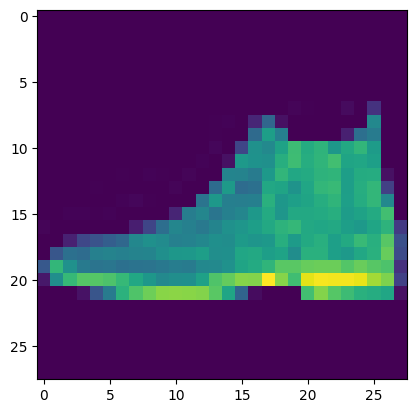

IMAGE 2
     LABEL: 2


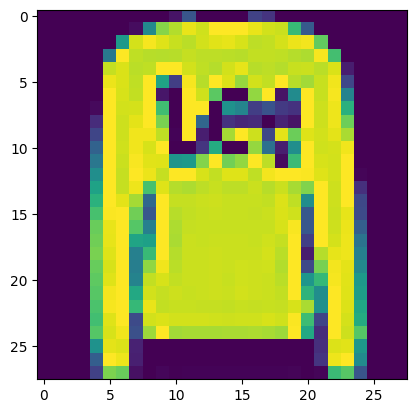

IMAGE 3
     LABEL: 1


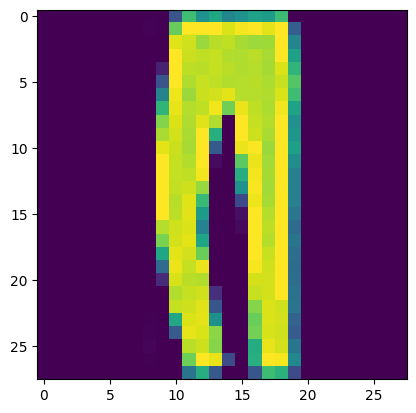

IMAGE 4
     LABEL: 1


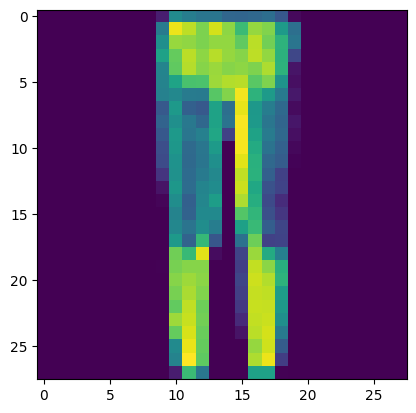

IMAGE 5
     LABEL: 6


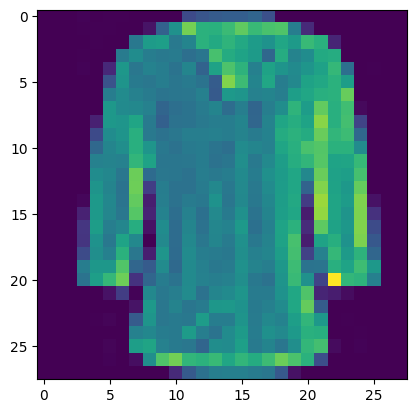

IMAGE 6
     LABEL: 1


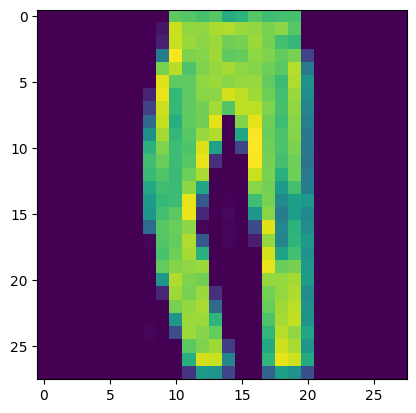

IMAGE 7
     LABEL: 4


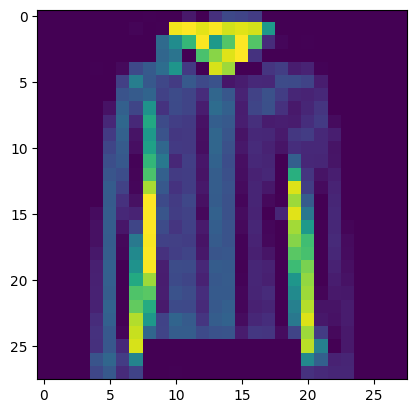

IMAGE 8
     LABEL: 6


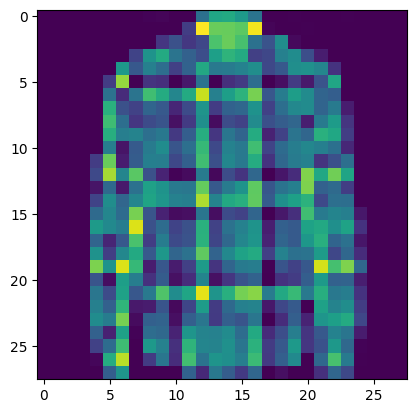

IMAGE 9
     LABEL: 5


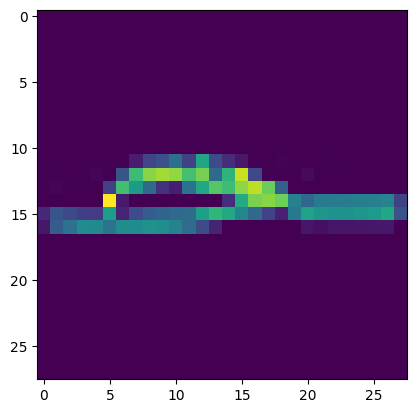

IMAGE 10
     LABEL: 7


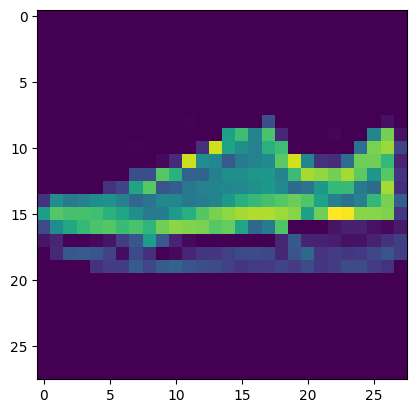

In [23]:
from matplotlib import pyplot as plt

f_mnist_test_images, test_data_loader, f_mnist_transforms =  get_fashion_mnist_test_data()
test_model = get_cnn_model_with_dropout_and_batch_normalization()

classification_tester = ClassificationTester(
  "fashion mnist", test_model, test_data_loader, f_mnist_transforms, CHECKPOINT_FILE_PATH
)
classification_tester.test()

print()

# 이미지 10개 출력
for i in range(10):
    img, label = f_mnist_test_images[i]
    print("IMAGE", i+1)
    print("     LABEL:", label)
    plt.imshow(img)
    plt.show()

[예측결과]

pullover와 coat의 경우, 두 가지 모두 상의이며, 비슷한 형태와 패턴을 가진 제품이 있다. 특히 일부 pullover는 coat와 유사한 디자인을 가지고 있어 이 두 카테고리간의 이미지 분류 예측을 어렵게 했다고 생각한다.

[숙제후기]

이번 과제를 하면서, 제일 먼저 modern cnn 모델로 작성하면 좀 더 좋은 validation_accuracy와 test_accuracy가 나올거라고 생각했다. 그러나, googlenet을 사용하면서, test_accuracy가 100에 가까울 정도로 좋은 결과를 내지만, 반대로 validation_accuracy 같은 경우에는 급상승하다가 중간지점에 validation_loss가 급상승하면서 떨어지는 현상을 보였다. overfitting 현상이 생겨서 그런 결과가 나오는 것이라고 생각하고, learning rate, batch size, early stop patience, weight decay value 등 과적합을 줄이기 위해 노력했지만, 오히려 더 좋지 않은 결과를 보였다. 그래서 googlenet이 아닌 cnn 모델을 학습시키는 방향으로 전환하게 되었다. model을 총 5개의 모델로 두고, 데이터를 학습시켜본 결과, 가장 좋은 결과를 가져온 모델은 get_cnn_model_with_dropout_and_batch_normalization 모델이였다. 그래서 이 모델을 바탕으로, learning rate, batch size, validation interval, optimizer, weight decay, dropout 등의 값을 조절시켜 결과를 냈다. 또한, 처음에는 get_fashion_mnist_test_data의 batch size를 모든 데이터를 다 살펴보도록 하였는데, 그렇게 하니 이미지를 출력하는 과정에서 kernel이 자꾸 죽는 현상이 발생하여 batch size를 128로 조정하여 결과를 내렸다. 그러나 모델이 test accurary가 validation accurary보다 높다는 점에서 어떠한 이유에서 이러한 결과가 나오는지 조금 더 생각해봐야갰다고 생각했다.